In [40]:
import matplotlib.pyplot as plt
from model_builder import build_cqm
from dotenv import load_dotenv, find_dotenv

In [41]:
from dimod import ConstrainedQuadraticModel, Integer, Binary, quicksum, QuadraticModel, BinaryQuadraticModel
from dwave.system import LeapHybridCQMSampler

In [42]:
# Load Environmental Variables
load_dotenv(find_dotenv())
token = os.environ['DWAVE_API_KEY'] 

In [43]:
import requests
import yaml

# URL of the online YAML file
yaml_url = 'https://raw.githubusercontent.com/IEAWindTask37/iea37-wflo-casestudies/master/cs1-2/iea37-windrose.yaml'
# Fetch the YAML content from the URL
response = requests.get(yaml_url)
yaml_data = response.text

# Load YAML data
data = yaml.safe_load(yaml_data)

# Extract the desired information
wind_speed_bins = data['definitions']['wind_inflow']['properties']['direction']['bins']
wind_speed_default = data['definitions']['wind_inflow']['properties']['speed']['default']
wind_speed_probability = data['definitions']['wind_inflow']['properties']['probability']['default']

# Convert the probability_default into a list
wind_speed_probability = [float(val) for val in wind_speed_probability]

# Store the information in a dictionary
wind_data = {
    'bins': wind_speed_bins,
    'wind_speed_default': wind_speed_default,
    'probability': wind_speed_probability
}

# Print the extracted data
print(wind_data)


{'bins': [0.0, 22.5, 45.0, 67.5, 90.0, 112.5, 135.0, 157.5, 180.0, 202.5, 225.0, 247.5, 270.0, 292.5, 315.0, 337.5], 'wind_speed_default': 9.8, 'probability': [0.025, 0.024, 0.029, 0.036, 0.063, 0.065, 0.1, 0.122, 0.063, 0.038, 0.039, 0.083, 0.213, 0.046, 0.032, 0.022]}


In [44]:
# URL of the online YAML file
yaml_url = 'https://raw.githubusercontent.com/IEAWindTask37/iea37-wflo-casestudies/master/cs1-2/iea37-335mw.yaml'

# Fetch the YAML content from the URL
response = requests.get(yaml_url)
yaml_data = response.text

# Load YAML data
data = yaml.safe_load(yaml_data)

# Extract the wind_turbine_lookup default value
wind_turbine_power = data['definitions']['wind_turbine_lookup']['properties']['power']['maximum']/1e6

# Print the extracted default value
print("wind_turbine_power:", wind_turbine_power)


wind_turbine_power: 3.35


In [45]:
#Extract the "Rotor Radius"
rotor_radius = data['definitions']['rotor']['properties']['radius']['default']
print("rotor_radius:", rotor_radius)

# Extract the "Cut-In Wind Speed"
cut_in_wind_speed = data['definitions']['operating_mode']['properties']['cut_in_wind_speed']['default']

# Print the extracted "Cut-In Wind Speed"
print("Cut-In Wind Speed:", cut_in_wind_speed)

# Extract the "Cut-Out Wind Speed"
cut_out_wind_speed = data['definitions']['operating_mode']['properties']['cut_out_wind_speed']['default']

# Print the extracted "Cut-Out Wind Speed"
print("Cut-Out Wind Speed:", cut_out_wind_speed)

# Extract the "Rated Wind Speed"
rated_wind_speed = data['definitions']['operating_mode']['properties']['rated_wind_speed']['default']

# Print the extracted "Rated Wind Speed"
print("Rated Wind Speed:", rated_wind_speed)

# Extract the "Hub Height"
hub_height = data['definitions']['hub']['properties']['height']['default']

# Print the extracted "Hub Height"
print("Hub Height:", hub_height)

rotor_radius: 65.0
Cut-In Wind Speed: 4.0
Cut-Out Wind Speed: 25.0
Rated Wind Speed: 9.8
Hub Height: 110.0


In [46]:
def WindFrame(turb_coords, wind_dir_deg):
    """Convert map coordinates to downwind/crosswind coordinates."""

    # Convert from meteorological polar system (CW, 0 deg.=N)
    # to standard polar system (CCW, 0 deg.=W)
    # Shift so North comes "along" x-axis, from left to right.
    wind_dir_deg = 270. - wind_dir_deg
    # Convert inflow wind direction from degrees to radians
    wind_dir_rad = DegToRad(wind_dir_deg)

    # Constants to use below
    cos_dir = np.cos(-wind_dir_rad)
    sin_dir = np.sin(-wind_dir_rad)
    # Convert to downwind(x) & crosswind(y) coordinates
    frame_coords = np.recarray(turb_coords.shape, coordinate)
    frame_coords.x = (turb_coords.x * cos_dir) - (turb_coords.y * sin_dir)
    frame_coords.y = (turb_coords.x * sin_dir) + (turb_coords.y * cos_dir)

    return frame_coords

In [47]:
def GaussianWake(frame_coords, turb_diam):
    """Return each turbine's total loss due to wake from upstream turbines"""
    # Equations and values explained in <iea37-wakemodel.pdf>
    num_turb = len(frame_coords)

    # Constant thrust coefficient
    CT = 4.0*1./3.*(1.0-1./3.)
    # Constant, relating to a turbulence intensity of 0.075
    k = 0.0324555
    # Array holding the wake deficit seen at each turbine
    loss = np.zeros(num_turb)

    for i in range(num_turb):            # Looking at each turb (Primary)
        loss_array = np.zeros(num_turb)  # Calculate the loss from all others
        for j in range(num_turb):        # Looking at all other turbs (Target)
            x = frame_coords.x[i] - frame_coords.x[j]   # Calculate the x-dist
            y = frame_coords.y[i] - frame_coords.y[j]   # And the y-offset
            if x > 0.:                   # If Primary is downwind of the Target
                sigma = k*x + turb_diam/np.sqrt(8.)  # Calculate the wake loss
                # Simplified Bastankhah Gaussian wake model
                exponent = -0.5 * (y/sigma)**2
                radical = 1. - CT/(8.*sigma**2 / turb_diam**2)
                loss_array[j] = (1.-np.sqrt(radical)) * np.exp(exponent)
            # Note that if the Target is upstream, loss is defaulted to zero
        # Total wake losses from all upstream turbs, using sqrt of sum of sqrs
        loss[i] = np.sqrt(np.sum(loss_array**2))

    return loss

In [48]:
def DirPower(turb_coords, wind_dir_deg, wind_speed,
             turb_diam, turb_ci, turb_co, rated_ws, rated_pwr):
    """Return the power produced by each turbine."""
    num_turb = len(turb_coords)

    # Shift coordinate frame of reference to downwind/crosswind
    frame_coords = WindFrame(turb_coords, wind_dir_deg)
    # Use the Simplified Bastankhah Gaussian wake model for wake deficits
    loss = GaussianWake(frame_coords, turb_diam)
    # Effective windspeed is freestream multiplied by wake deficits
    wind_speed_eff = wind_speed*(1.-loss)
    # By default, the turbine's power output is zero
    turb_pwr = np.zeros(num_turb)

    # Check to see if turbine produces power for experienced wind speed
    for n in range(num_turb):
        # If we're between the cut-in and rated wind speeds
        if ((turb_ci <= wind_speed_eff[n])
                and (wind_speed_eff[n] < rated_ws)):
            # Calculate the curve's power
            turb_pwr[n] = rated_pwr * ((wind_speed_eff[n]-turb_ci)
                                       / (rated_ws-turb_ci))**3
        # If we're between the rated and cut-out wind speeds
        elif ((rated_ws <= wind_speed_eff[n])
                and (wind_speed_eff[n] < turb_co)):
            # Produce the rated power
            turb_pwr[n] = rated_pwr

    # Sum the power from all turbines for this direction
    pwrDir = np.sum(turb_pwr)

    return pwrDir

In [49]:
def calcAEP(turb_coords, wind_freq, wind_speed, wind_dir,
            turb_diam, turb_ci, turb_co, rated_ws, rated_pwr):
    """Calculate the wind farm AEP."""
    num_bins = len(wind_freq)  # Number of bins used for our windrose

    #  Power produced by the wind farm from each wind direction
    pwr_produced = np.zeros(num_bins)
    # For each wind bin
    for i in range(num_bins):
        # Find the farm's power for the current direction
        pwr_produced[i] = DirPower(turb_coords, wind_dir[i], wind_speed,
                                   turb_diam, turb_ci, turb_co,
                                   rated_ws, rated_pwr)

    #  Convert power to AEP
    hrs_per_year = 365.*24.
    AEP = hrs_per_year * (wind_freq * pwr_produced)
    #AEP /= 1.E6  # Convert to MWh

    return AEP


In [50]:
def create_concentric_grids(num_grids, num_points_per_grid, boundary_radius, midpoint):
    concentric_grids = []
    for i in range(num_grids):
        radius = boundary_radius * (i + 1) / num_grids
        grid_points = create_circular_grid(radius, num_points_per_grid, midpoint)
        concentric_grids.extend(grid_points)

    # Add (0, 0) only if it hasn't been added before
    if not any(point == (0.0, 0.0) for point in concentric_grids):
        concentric_grids.append((0.0, 0.0))

    return concentric_grids

def create_circular_grid(radius, num_points, midpoint):
    points = []

    for i in range(num_points):
        angle_degrees = 360.0 * i / num_points
        shifted_angle_degrees = (angle_degrees + midpoint) % 360.0  # Apply the shift
        new_point = (shifted_angle_degrees, radius)
        # Include (0, 0) in the list only if it hasn't been added before
        if new_point not in points and new_point != (0.0, 0.0):
            points.append(new_point)

    return points


In [1]:
def solve(cqm, time_limit=5):

  """
    Solve the Constrained Quadratic Model (CQM) using the LeapHybridCQMSampler.

    Args:
        cqm (ConstrainedQuadraticModel): The Constrained Quadratic Model to solve.
        time_limit (int): Time limit in seconds for the solver.

    Returns:
        sampleset (SampleSet): The resulting sampleset from the solver.
    """

  sampler = LeapHybridCQMSampler(token=token)
  print("Submitting CQM to solver {}.".format(sampler.solver.name))
  sampleset = sampler.sample_cqm(cqm, label='WFLOP_CS1', time_limit=time_limit)
  return sampleset

In [52]:
def parse_solution(sampleset):

  """
    Parse the solution from the sampleset obtained from the solver.

    Args:
        sampleset (SampleSet): The sampleset obtained from the solver.

    Returns:
        energy (float): The energy of the best solution.
        non_zero_values (dict): Dictionary of non-zero values in the best solution.
    Raises:
        ValueError: If no feasible solution is found in the sampleset.
    """

  feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)
  if not len(feasible_sampleset):
    raise ValueError("No feasible solution found")
  
  solution = feasible_sampleset.first.sample
  non_zero_values = {key: int(value) for key, value in solution.items() if value != 0}
  energy = feasible_sampleset.first.energy
  
  return energy, non_zero_values

In [53]:
def polar_to_cartesian(polar_coords):
    return [(radius * np.cos(np.radians(angle)), radius * np.sin(np.radians(angle))) for angle, radius in polar_coords]

def print_solution(solution):
    """
    Print the selected wind towers and their corresponding Cartesian coordinates.

    Parameters:
    - solution (dict): A dictionary representing the selected wind towers and their binary values.

    Returns:
    - None
    """

    selected_towers = []

    for var_name, value in solution.items():
        if value == 1:
            # Parse the variable name to extract angle and radius
            parts = var_name.split('_')
            if len(parts) == 2:  # Check if there are two parts in the variable name
                angle = float(parts[0])
                radius = float(parts[1])
                selected_towers.append((angle, radius))

    # Convert polar coordinates to Cartesian coordinates
    cartesian_coords = polar_to_cartesian(selected_towers)

    # Display the result
    for polar, cartesian in zip(selected_towers, cartesian_coords):
        print(f"Polar: {polar} => Cartesian: {cartesian}")

    # Create a scatter plot for Cartesian coordinates
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    xc, yc = zip(*cartesian_coords)
    plt.scatter(xc, yc, marker='o', c='b')

    # Add labels to Cartesian plot
    for i, (x, y) in enumerate(zip(xc, yc), start=1):
        plt.text(x, y, str(i), color='red', fontsize=8)

    # Customize the Cartesian plot
    plt.title("Cartesian Coordinates")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.grid(True)

    # Convert Cartesian to polar
    r = np.sqrt(np.array(xc) ** 2 + np.array(yc) ** 2)
    theta = np.arctan2(yc, xc)

    # Create a scatter plot for polar coordinates
    plt.subplot(1, 2, 2, projection='polar')
    plt.scatter(theta, r, marker='o', c='b')

    # Add labels to polar plot
    for i, (t, rad) in enumerate(zip(theta, r), start=1):
        plt.text(t, rad, str(i), color='red', fontsize=20)

    for bin_angle in wind_speed_bins:
        plt.axvline(np.radians(bin_angle), linestyle='dashed', color='gray', alpha=0.5)

    # Customize the polar plot
    plt.title("Polar Coordinates")
    plt.grid(True)

    # Show both plots
    plt.tight_layout()
    plt.show()

def get_solution_coordinates(solution):
    """
    Get the Cartesian coordinates of the selected wind towers based on the given solution.

    Parameters:
    - solution (dict): A dictionary representing the selected wind towers and their binary values.

    Returns:
    - list: A list containing the Cartesian coordinates of each selected wind tower.
    """

    selected_towers = []

    for var_name, value in solution.items():
        if value == 1:
            # Parse the variable name to extract angle and radius
            parts = var_name.split('_')
            if len(parts) == 2:  # Check if there are two parts in the variable name
                angle = float(parts[0])
                radius = float(parts[1])
                selected_towers.append((angle, radius))

    # Convert polar coordinates to Cartesian coordinates
    cartesian_coords = polar_to_cartesian(selected_towers)

    return cartesian_coords


In [54]:
# Define the number of turbines
n_turbines = 16

# Define the yearly operative working hours of the farm
yearly_working_hours = 8760

# Define the boundary radius in meters
boundary_radius = 1300

# Calculate the diameter from the radius
diameter = 2 * rotor_radius

# Define the minimum distance as 2 times the rotor diameter
minimum_distance = 2 * diameter

# Print the minimum distance
print("Minimum Distance:", minimum_distance)

Minimum Distance: 260.0


(11.25, 100.0)
(22.5, 100.0)
(33.75, 100.0)
(45.0, 100.0)
(56.25, 100.0)
(67.5, 100.0)
(78.75, 100.0)
(90.0, 100.0)
(101.25, 100.0)
(112.5, 100.0)
(123.75, 100.0)
(135.0, 100.0)
(146.25, 100.0)
(157.5, 100.0)
(168.75, 100.0)
(180.0, 100.0)
(191.25, 100.0)
(202.5, 100.0)
(213.75, 100.0)
(225.0, 100.0)
(236.25, 100.0)
(247.5, 100.0)
(258.75, 100.0)
(270.0, 100.0)
(281.25, 100.0)
(292.5, 100.0)
(303.75, 100.0)
(315.0, 100.0)
(326.25, 100.0)
(337.5, 100.0)
(348.75, 100.0)
(0.0, 100.0)
(11.25, 200.0)
(22.5, 200.0)
(33.75, 200.0)
(45.0, 200.0)
(56.25, 200.0)
(67.5, 200.0)
(78.75, 200.0)
(90.0, 200.0)
(101.25, 200.0)
(112.5, 200.0)
(123.75, 200.0)
(135.0, 200.0)
(146.25, 200.0)
(157.5, 200.0)
(168.75, 200.0)
(180.0, 200.0)
(191.25, 200.0)
(202.5, 200.0)
(213.75, 200.0)
(225.0, 200.0)
(236.25, 200.0)
(247.5, 200.0)
(258.75, 200.0)
(270.0, 200.0)
(281.25, 200.0)
(292.5, 200.0)
(303.75, 200.0)
(315.0, 200.0)
(326.25, 200.0)
(337.5, 200.0)
(348.75, 200.0)
(0.0, 200.0)
(11.25, 300.0)
(22.5, 300.0)

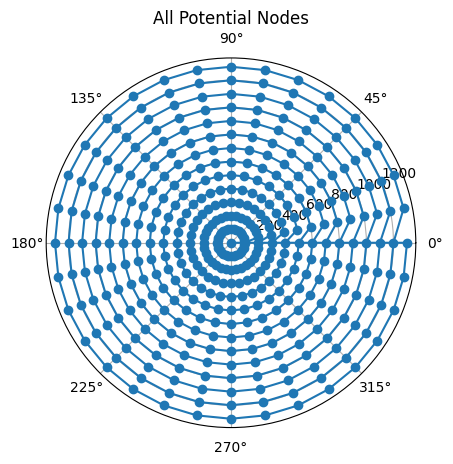

In [55]:
# Define the number of nodes to discretize the area
num_grids = 13
num_points_per_grid = 32
midpoint = 360/ len(wind_speed_bins)/2
concentric_grids = create_concentric_grids(num_grids, num_points_per_grid, boundary_radius, midpoint)

# Print angles and radii of points
for point in concentric_grids:
    angle, radius = point
    print(f"({angle}, {radius})")

# Plot all potential nodes
angles, radii = zip(*concentric_grids)
plt.polar(np.radians(angles), radii, marker='o')

plt.title("All Potential Nodes")
plt.show()

In [56]:
# Identify the labels for the discrete DV as nodes in polar coordinates inside the area available
potential_nodes = [(round(angle, 1), round(radius)) for angle, radius in concentric_grids]
wind_tower_labels = [f'{angle}_{radius:.0f}' for angle, radius in potential_nodes]

In [57]:
coordinate = np.dtype([('x', 'f8'), ('y', 'f8')])

Submitting CQM to solver hybrid_constrained_quadratic_model_version1.
Polar: (0.0, 0.0) => Cartesian: (0.0, 0.0)
Polar: (101.2, 1300.0) => Cartesian: (-252.50465658596355, 1275.241701953949)
Polar: (11.2, 1300.0) => Cartesian: (1275.241701953949, 252.50465658596355)
Polar: (123.8, 1000.0) => Cartesian: (-556.2956155003048, 830.9844692743283)
Polar: (146.2, 1300.0) => Cartesian: (-1080.2798100566265, 723.1843001503966)
Polar: (168.8, 1000.0) => Cartesian: (-980.9551553491915, 194.23435121997193)
Polar: (191.2, 1300.0) => Cartesian: (-1275.2417019539491, -252.50465658596318)
Polar: (213.8, 1000.0) => Cartesian: (-830.9844692743283, -556.2956155003048)
Polar: (236.2, 1300.0) => Cartesian: (-723.1843001503961, -1080.279810056627)
Polar: (258.8, 1000.0) => Cartesian: (-194.23435121997153, -980.9551553491916)
Polar: (281.2, 1300.0) => Cartesian: (252.5046565859637, -1275.241701953949)
Polar: (303.8, 1000.0) => Cartesian: (556.2956155003052, -830.984469274328)
Polar: (326.2, 1300.0) => Cartes

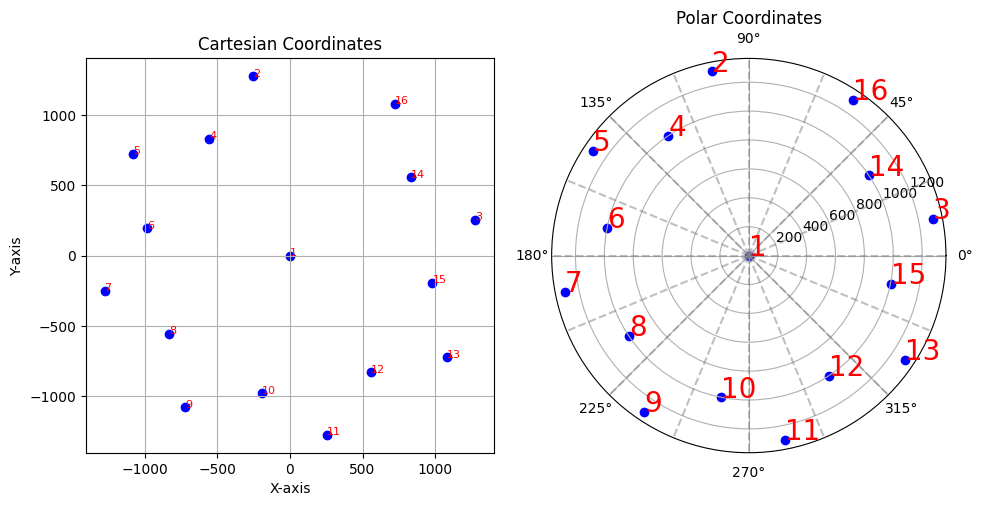

In [58]:
#  Initialize CQM
cqm = build_cqm (wind_tower_labels, coordinate, wind_speed_bins,rated_wind_speed, diameter, 
              cut_in_wind_speed, cut_out_wind_speed,wind_turbine_power, wind_speed_probability,
              DirPower, n_turbines, potential_nodes, minimum_distance)

#  Instantiate the sampler
sampleset = solve(cqm)

# Parse solution
energy, solution = parse_solution(sampleset)

#  Print solution in a human readable diagram
print_solution(solution)

In [59]:
cartesian_coords = get_solution_coordinates(solution)

# Transform Cartesian coordinates to the specified format
turb_xc = np.asarray([coord[0] for coord in cartesian_coords])
turb_yc = np.asarray([coord[1] for coord in cartesian_coords])

# Structured datatype for holding coordinate pair
turb_coords = np.recarray(turb_xc.shape, coordinate)
turb_coords.x, turb_coords.y = turb_xc, turb_yc

In [60]:
# Calculate the AEP from ripped values
AEP = calcAEP(turb_coords, wind_speed_probability, wind_speed_default, wind_speed_bins,
                diameter, cut_in_wind_speed, cut_out_wind_speed, rated_wind_speed, wind_turbine_power)

# Print AEP for each binned direction, with 5 digits behind the decimal.
print(np.array2string(AEP, precision=5, floatmode='fixed',
                        separator=', ', max_line_width=62))

# Print AEP summed for all directions
print(f"\nTotal Wind Farm AEP = {int(np.round(np.sum(AEP))):,} MWh")


[10292.05730,  9916.63388, 11703.83511, 14956.55426,
 26210.24164, 27078.30115, 41155.31088, 49799.60274,
 25905.00947, 15683.19390, 15858.51351, 34253.22305,
 88464.69495, 19198.45049, 13259.26536,  8914.05664]

Total Wind Farm AEP = 412,649 MWh
